In [1]:
#JAX imports
import os
os.environ['JAX_PLATFORMS'] = 'cpu' #Restrict CPU usage
import jax
import jax.numpy as jnp

#Additional regular imports
import numpy as np
import matplotlib.pyplot as plt
#Figure settings to avoid super large plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 90

# Session 3: Advanced JAX programming

## 1. From mathematics to optimized practical implementations

[Legendre polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials) are a popular system of orthogonal polynomials with many interesting theoretical and practical applications. They can be elegantly defined by means of the following recurrence relation:

$$P_{n}(x) = \frac{(2n -1)xP_{n-1}(x) - (n-1)P_{n-2}(x)}{n}$$

, where $n$ is the degree of the polynomial. As base cases, $P_0(x) = 1; P_1(x)=x$.

This definition leads to simple and elegant recursive implementation, as follows:

In [2]:
def legendre(n, x):
    if n == 0:
        return 1.
    elif n == 1:
        return x
    else:
        return ((2*n-1)*x*legendre(n-1, x)-(n-1)*legendre(n-2, x))/n

Let's give it a try and visualize how the polynomials look like:

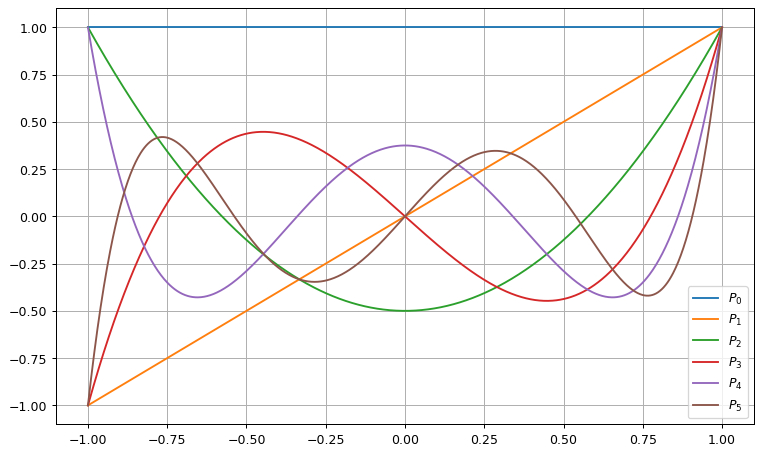

In [3]:
x = jnp.linspace(-1, 1, 1000)
for i in range(6):
    plt.plot(x, [legendre(i, xj) for xj in x], label=f'$P_{i}$')
plt.legend()
plt.grid()

Very nice implementation! But a bit inconvenient for using it on arrays and, as expected, we have a high penalty in terms of performance:

In [4]:
#How long it takes to calculate P_5 for the whole domain.
%timeit [legendre(5, xj) for xj in x]

181 ms ± 4.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### 📋 Exercise 1:

Using **exclusively** `jax.jit` and `jax.vmap`:
 - Provide an optimized implementation of `legendre()` so that it can directly calculate the value of the polynomial for the full `x` array in a single call. 

__Hints__:
 - Remember the `static_argnums` or `static_argnames` parameters of `jax.jit`.

5.22 µs ± 303 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


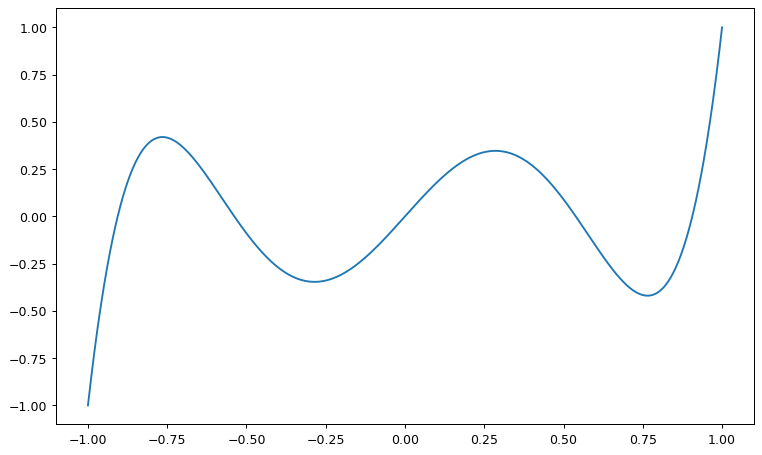

In [5]:
# Complete the code to provide a solution to Exercise 1:
legendre_fast = jax.jit(jax.vmap(legendre, (None, 0)), static_argnums=[0])
plt.plot(x, legendre_fast(5, x))
%timeit legendre_fast(5, x)

## 2. Advanced control flow

If you want to avoid recompilations with `static_argnums` and still keep jit-compatibility without unrolling large loops, there are 4 structured control flow primitives in JAX:

 - `lax.cond`  _differentiable_
 - `lax.while_loop` __fwd-mode-differentiable__
 - `lax.fori_loop` __fwd-mode-differentiable__ in general; __fwd and rev-mode differentiable__ if endpoints are static.
 - `lax.scan` _differentiable_

These are the Python equivalent implementations of these functions, to illustrate their semantics:

```python
def cond(pred, true_fun, false_fun, operand):
  if pred:
    return true_fun(operand)
  else:
    return false_fun(operand)

def while_loop(cond_fun, body_fun, init_val):
  val = init_val
  while cond_fun(val):
    val = body_fun(val)
  return val

def fori_loop(start, stop, body_fun, init_val):
  val = init_val
  for i in range(start, stop):
    val = body_fun(i, val)
  return val

def scan(f, init, xs, length=None):
  if xs is None:
    xs = [None] * length
  carry = init
  ys = []
  for x in xs:
    carry, y = f(carry, x)
    ys.append(y)
  return carry, np.stack(ys)
```

In this session we will focus on learning how to use `lax.scan`:
 - It is the only one looping primitive supporting both forward- and reverse-mode differentiation.
 - Their semantics are less intuitive than other primitives.

### Basic `scan` example: Calculation of compound interests

In short, `scan` traverses an input array through its leading axes, applying a function to each element while carrying a state calculated from all the previous elements. The function may use and update the carry arbitrarily, but always keeping the same data shape.

Let's illustrate this behaviour with a basic example, in which we have an array with interests that are applied on each year, and we want to calculate the final value we would get from an initial investment, as long as all the intermediate values we would have at the end of each year.

In [6]:
def compound_interests(init, interests):
    def eval_interests(carry, interest):
        new_val = carry * interest
        new_carry = new_val
        return new_carry, new_val

    history, final_value = jax.lax.scan(eval_interests, init, interests)
    return history, final_value

initial_investment = 1000.0
interests = jnp.array([1.02, 1.001, 1.016, 1.023, 1.025, 1.038, 1.042, 1.03, 1.01, 1.018])
history, final_value = compound_interests(initial_investment, interests)
print(history)
print(final_value)

1245.9452
[1020.     1021.02   1037.3563 1061.2156 1087.746  1129.0803 1176.5017
 1211.7968 1223.9147 1245.9452]


### Implementing recurrences with `jax.lax.scan`

We have seen in our first example on the calculation of Legendre polynomials that, to some extent, `jax.jit` is friendly with recursive functions. However, `lax.scan` is a more powerful tool to implement this type of patterns in an iterative way. This can be done by playing with the `carry` state, in which we can **store all the information required from recursive calls**. Let's show an example with one of the most classical recurrent sequence: The [Fibonacci numbers](https://en.wikipedia.org/wiki/Fibonacci_sequence):

Mathematically, the n-th Fibonacci number is defined as:

$$F_n = F_{n-1} + F_{n-2}$$

, where $F_0=0$ and $F_1=1$.

To calculate this sequence using `lax.scan`, we can proceed as follows:

In [7]:
def fib_scan(n):
    # Function to be used in scan
    def body(carry, _):
        a, b = carry #The state is a tuple, but may be an array, a dictionary...
        return (b, a + b), a  # Update state and output the current Fibonacci number

    # Initial state: (F_0, F_1)
    init_state = (0, 1)

    # Perform the scan
    _, fibs = jax.lax.scan(body, init_state, None, length=n)
    return fibs

print(fib_scan(10))

[ 0  1  1  2  3  5  8 13 21 34]


#### 📋 Exercise 2:

Suppose we are interested in building a function space with Legendre polynomials as basis functions. In this case, it would be very convenient to calculate **all polynomials up to a certain degree**, and not just a single one as we did in the `legendre` or `legendre_fast` functions. So:

 - Using `jax.lax.scan`, provide a function that calculates all Legendre polynomials up to a certain degree for the a given domain with a single call.

__Hints:__
 - In the carrying state, try to store all the information you would require from recursive calls.
 - The iteration should be done on the polynomial degree, not on `x`.

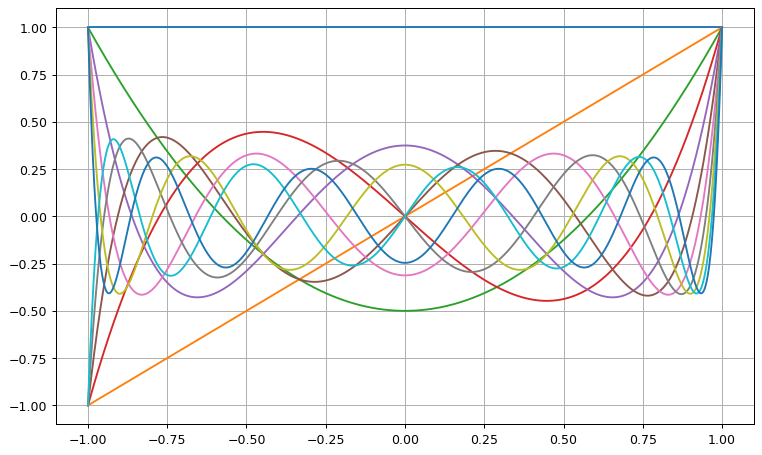

In [8]:
# Complete the code to provide a solution to Exercise 2:
def legendre_full(n, x):

    def eval_legendre(carry, _):
        n, (p_nm1, p_nm2) = carry
        p_n = ((2*n-1)*x*p_nm1-(n-1)*p_nm2)/n
        return (n+1, (p_n, p_nm1)), p_n

    carry, out = jax.lax.scan(f=eval_legendre,
                              init= (2, (x, jnp.ones_like(x))),
                              xs=None, length=n-1)
    return jnp.vstack([jnp.ones_like(x), x, out])

out = legendre_full(10, x)
plt.plot(x, out.T)
plt.grid()

If we compare now the speed of the different implementations, we can see how much we have advanced in this rather short journey:

In [9]:
%timeit jax.jit(legendre_full, static_argnums=[0])(10, x)
%timeit jnp.vstack([legendre_fast(i, x) for i in range(11)])
%timeit [[legendre(i, xj) for xj in x] for i in range(11)]

42.9 µs ± 409 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
495 µs ± 71.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.41 s ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 3. Advanced gradient calculation

One of the main advantages of JAX is that, from this implementation the derivative of the Legendre polynomials can be automatically obtained. However, **this is not totally trivial**. Let's start with some theoretical notes to give a better context:

### The Working Principles of Automatic Differentiation (AD)

 - AD is neither [numerical differentiation](https://en.wikipedia.org/wiki/Numerical_differentiation) (i.e., finite differences) nor [symbolic differentiation](https://en.wikipedia.org/wiki/Symbolic_differentiation), but has aspects of both.
 - Working principle: Any differentiable function $F:\mathbb{R}^n \rightarrow \mathbb{R}^m$ can be described as the **composition of elementary functions for which the exact derivative is known**.
     -  Then, the **[chain rule](https://en.wikipedia.org/wiki/Chain_rule)** is applied on this composition.

**Example:**

$$F = D\circ C \circ B \circ A\\ y=F(x) = D(C(B(A(x))))$$

then, if we name: $\mathbf{a}=A(x), \mathbf{b}=B(\mathbf{a}), \mathbf{c}=C(\mathbf{b}), y=D(\mathbf{c})$, we have that:

\begin{equation*}
F'(x) = \frac{\partial y}{\partial \mathbf{c}} \frac{\partial \mathbf{c}}{\partial \mathbf{b}} \frac{\partial \mathbf{b}}{\partial \mathbf{a}} \frac{\partial \mathbf{a}}{\partial x} \tag{1}
\end{equation*}

Basically everything about AD is the calculation of the above expression in a **computationally efficient** manner, and for this there are two main strategies: forward-mode and reverse-mode.

##### TLDR; Forward-mode vs. Reverse-mode Differentiation:

Considering a target function $F:\mathbb{R}^n \rightarrow \mathbb{R}^m$:
 - Reverse-mode differentiation is much more computationally efficient if $n >> m$ (requires running $F$ $m$ times, and building a call graph for backward accumulation).
 - Forward-mode differentiation is much more computationally efficient if $m >> n$, and is always much more memory-efficient (requires running $F$ $n$ times).

### AD Flavors: Forward-Mode and Reverse-Mode

There are two main approaches for calculating equation (1), depending on the order followed to accumulate the gradients of each elementary function, which give name to the classical methods of AD: forward-mode and reverse-mode. Conceptually, the difference is as simple as:

 - Forward mode: $F'(x) = \frac{\partial y}{\partial \mathbf{c}} \left( \frac{\partial \mathbf{c}}{\partial \mathbf{b}} \left( \frac{\partial \mathbf{b}}{\partial \mathbf{a}} \frac{\partial \mathbf{a}}{\partial x} \right) \right)$. Derivatives are calculated following the same order as function evaluation, from inputs to outputs.
 
 
 - Reverse mode: $F'(x) = \left( \left(\frac{\partial y}{\partial \mathbf{c}} \frac{\partial \mathbf{c}}{\partial \mathbf{b}} \right) \frac{\partial \mathbf{b}}{\partial \mathbf{a}} \right) \frac{\partial \mathbf{a}}{\partial x}$. Derivatives are calculated in the inverse order as function evaluation, from outputs to inputs.

This innocent-looking difference has huge implications in terms of **computational complexity and memory consumption**. Let's see an specific example:
 - $f(x_1, x_2) = x_1x_2 + sin(x_1)$
 - The animations are shown over a *call graph* determining the order of evaluation of the elementary functions composing $f$:

In [12]:
from IPython.display import IFrame
IFrame(src="https://docs.google.com/presentation/d/e/2PACX-1vS5GANK-J-iXK2jwlc4XgJbD3o67Isq90hGAC0Pgb_wFP_VAc3Evgpmu45fBRTh8wA46qAQ8pywWHEM/embed?start=false&loop=false", width="800", height="475")

**Forward-mode**:
 - ✅ The derivative values $w$ are calculated **along with the execution** of the function, in the same normal evaluation.
 - ✅ Extremely **memory-efficient** implementation, with basically no overhead.
 - 📛 We need to run the function **as many times as the number of input variables we have**.
     - In practice, forward-mode is equivalent to finite differences in terms of complexity (memory and time).

**Reverse-mode**:
 - ✅ We calculate the derivatives with respect to all input variables **in a single forward-backward pass**.
     - *Adjoint variables* $ŵ$ start from the output and define which **calculations** are required at each edge to estimate the derivative of the output with respect to the inputs.
     - Once we have calculated the output of the function, we can solve all the adjoint expressions by going backwards in the call graph and obtain the derivatives with respect to all inputs at once.
 - 📛 If we have **multiple outputs, we need to solve the adjoint expressions once for each output**.
 - 📛 The call graph needs to be stored in memory.

### How AD is Actually Implemented (in JAX)

As an abstraction principle, JAX's AD subsystem is based on the notion of [Jacobian Matrices](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant), their composition and decomposition. As illustrated in the image below, the chain rule is then seen as the multiplication of the jacobian matrices for each of the elementary functions, and the forward and reverse modes correspond to the order of matrix multiplication (forward=right-to-left, reverse=left-to-right):

<img style="margin:auto" src="assets/jacobians_mult.svg" width="500"/>

This picture shows clearly which are the use cases more favorable to forward and reverse modes: In case $F$ is a scalar function, reverse mode is reduced to vector-matrix multiplications.

But, why is all this necessary? Coming back to our Legendre polynomials example, if we try to get the gradients of `legendre_full` as it would be expected:

In [10]:
dlegendre_full = jax.grad(legendre_full, argnums=1)
dlegendre_full(5, x)

TypeError: Gradient only defined for scalar-output functions. Output had shape: (6, 1000).

`jax.grad` only accepts functions **with scalar outputs**. And, even if the original `legendre` function **is indeed scalar**, all the transformations we did in terms of vectorization have hidden this property. Indeed, if we start from the original function:

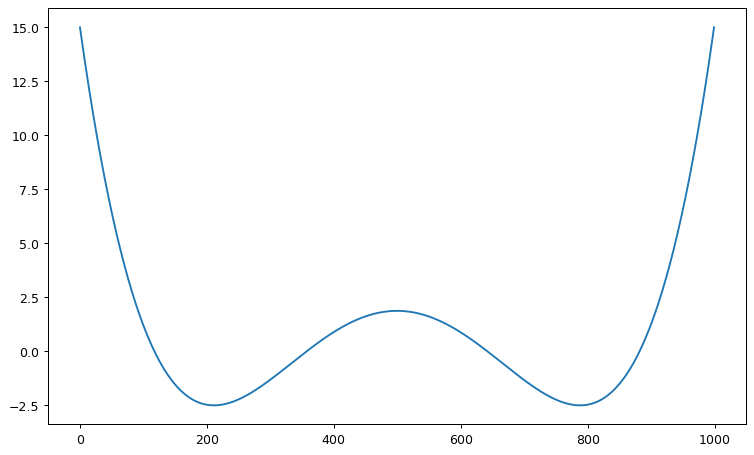

In [11]:
dlegendre = jax.grad(legendre, argnums=1)
plt.plot([dlegendre(5, xi) for xi in x])

#### 📋 Exercise 3:

Starting from `dlegendre`, provide an efficient implementation of `dlegendre_fast` following the same procedure used to create `legendre_fast`. Then, compare the speedup of the derivative calculations with the speedup of the original functions.

In [12]:
# Complete the code to provide a solution to Exercise 3:
dlegendre_fast = jax.jit(jax.vmap(dlegendre, (None, 0)), static_argnums=[0])
%timeit [dlegendre(5, xi) for xi in x]
%timeit dlegendre_fast(5, x)

7.92 s ± 83.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.16 µs ± 214 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


 - Still, it is not possible to follow this approach to calculate the derivatives of `legendre_full`
     - We would have to manually implement the derivative equation inside the function used in `lax.scan`.
 -  Jax provides [more advanced and fine-grained gradient-calculation functions](https://docs.jax.dev/en/latest/notebooks/autodiff_cookbook.html).
     -  We need to start thinking about [`jacobians`](https://docs.jax.dev/en/latest/_autosummary/jax.jacobian.html):

In [13]:
jac_legendre_full = jax.jit(jax.jacobian(legendre_full, argnums=1), static_argnums=[0])
jacobian_x = jac_legendre_full(5, x)
print(jacobian_x)
print(jacobian_x.shape)

[[[ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  ...
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]]

 [[ 1.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         1.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         1.        ...  0.         0.         0.       ]
  ...
  [ 0.         0.         0.        ...  1.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         1.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         1.       ]]

 [[-3.         0.         0.        ...  0.         0.         0.       ]
  [ 0.        -2.99399

Unfortunately, the jacobian matrix (as it should) calculates the partial derivatives of the full output **with respect to every input**.
 - Extremely sparse matrix
 - Only values on the diagonal of every $1000 \times 1000$ tensor are meaningful.

We can solve this by selecting the diagonals as follows:

(6, 1000)


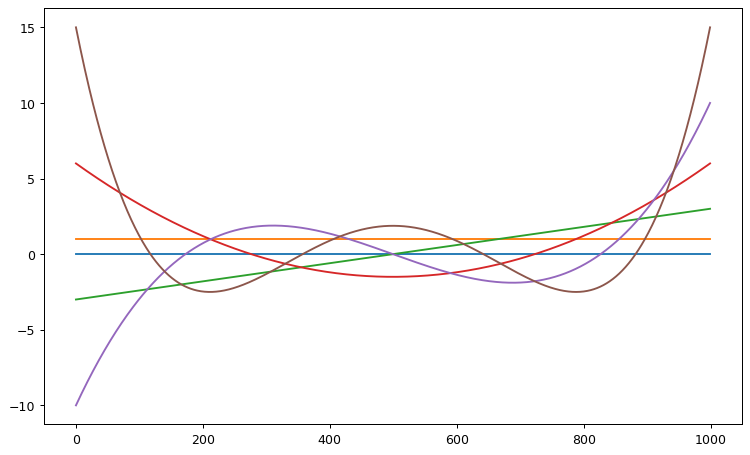

In [14]:
jacobian_x_fixed = jax.numpy.diagonal(jacobian_x, 0, 1, 2)
print(jacobian_x_fixed.shape)
plt.plot(jacobian_x_fixed.T)

Let's assess and compare the performance of the two implementations:

In [15]:
%timeit jnp.vstack([dlegendre_fast(i, x) for i in range(6)])
%timeit jnp.diagonal(jac_legendre_full(5, x), 0, 1, 2)

117 µs ± 1.87 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
115 ms ± 8.64 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


We can see that the overhead of calculating the full jacobian + posterior diagonalization is huge (in the same order of magnitude than the input, as it could be expected). 

Still, there is one factor we have not taken into account yet: `jax.jacobian`, is equivalent to [`jax.jacrev`](https://docs.jax.dev/en/latest/_autosummary/jax.jacrev.html#jax.jacrev) and uses **reverse-mode differentiation**. 
 - In our case, the output of `legendre_full` is larger than its input, as it goes from $len(x)$ to $n\times len(x)$.
 - Theory says this is a best-suited case for **forward-mode differentiation**. Let's use ([`jax.jacfwd`](https://docs.jax.dev/en/latest/_autosummary/jax.jacfwd.html)) for comparison:

In [16]:
jac_legendre_full_fwd = jax.jit(jax.jacfwd(legendre_full, argnums=1), static_argnums=[0])
%timeit jnp.diagonal(jac_legendre_full_fwd(5, x), 0, 1, 2)

30.3 ms ± 18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can see that, indeed, the performance improvement of forward-mode differentiation in this case is approximately 10x! Still, we are almost 100x slower than calculating the derivative for each polynomial and stack the results 🥲.

If we want to calculate the derivative of `legendre_full` in a proper and efficient way, we should make use of the **most advanced (and complex) differentiation functions**:
 - [`jax.jvp`](https://docs.jax.dev/en/latest/_autosummary/jax.jvp.html): *Jacobian-vector product*.
 - [`jax.vjp`](https://docs.jax.dev/en/latest/_autosummary/jax.vjp.html): *vector-Jacobian product*.

These are respectively the **[foundational autodiff functions](https://docs.jax.dev/en/latest/notebooks/autodiff_cookbook.html#how-it-s-made-two-foundational-autodiff-functions)** of Jax for forward- and reverse-mode differentiation.

 - They directly compute the product of the jacobian with an arbitrary vector, **avoiding computing the full jacobian**.
     - Thus, if we can define the diagonalization applied to the Jacobian as a a matrix-vector or vector-matrix product (or a set of them), it will be possible to directly calculate the desired gradients with `jvp` and/or `vjp`.

Let's start with `jvp`, since it is generally more straightforward to use. This is the interface of the function:
```python
def jax.jvp(fun, primals, tangents, has_aux=False):
    """
     Parameters:
        fun: Function to be differentiated. Its arguments should be arrays, scalars,
          or standard Python containers of arrays or scalars. It should return an
          array, scalar, or standard Python container of arrays or scalars.
        primals: The primal values at which the Jacobian of ``fun`` should be
          evaluated. Should be either a tuple or a list of arguments,
          and its length should be equal to the number of positional parameters of
          ``fun``.
        tangents: The tangent vector for which the Jacobian-vector product should be
          evaluated. Should be either a tuple or a list of tangents, with the same
          tree structure and array shapes as ``primals``.
        has_aux: Optional, bool. Indicates whether ``fun`` returns a pair where the
         first element is considered the output of the mathematical function to be
         differentiated and the second element is auxiliary data. Default False.
    
      Returns:
        If ``has_aux`` is ``False``, returns a ``(primals_out, tangents_out)`` pair,
        where ``primals_out`` is ``fun(*primals)``,
        and ``tangents_out`` is the Jacobian-vector product of
        ``function`` evaluated at ``primals`` with ``tangents``. The
        ``tangents_out`` value has the same Python tree structure and shapes as
        ``primals_out``. If ``has_aux`` is ``True``, returns a
        ``(primals_out, tangents_out, aux)`` tuple where ``aux``
        is the auxiliary data returned by ``fun``.
    """
```

First, we need to figure out which specific *vector* we need for the jacobian-vector product. In this case, we can see that just a vector of ones would do the trick:

In [17]:
print(jnp.allclose(jacobian_x_fixed, jnp.matmul(jacobian_x, jnp.ones_like(x))))

True


Then, we just need to adapt this operation to the interface of the `jvp` function, as follows:

In [18]:
# Simplified definition of the function to have a single parameter
legendre_full5 = jax.jit(lambda x: legendre_full(5, x))
# Calculation of jvp with a vector of ones to get the meaningful derivatives
ones = jnp.ones_like(x)
fx, dfx = jax.jvp(legendre_full5, [x], [ones])
# Check that the result is the expected one
print(jnp.allclose(jacobian_x_fixed, dfx, atol=1e-6))
%timeit jax.jvp(legendre_full5, [x], [ones])

True
153 µs ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### 📋 Exercise 4 (Optional):

Implement the same gradient calculation using `vjp`, and compare its performance with the one of `jvp`. This is the interface of the function:

```python
def jax.vjp(fun, primals, has_aux=False):
    """
    Parameters:
        fun: Function to be differentiated. Its arguments should be arrays, scalars,
          or standard Python containers of arrays or scalars. It should return an
          array, scalar, or standard Python container of arrays or scalars.
        primals: A sequence of primal values at which the Jacobian of ``fun``
          should be evaluated. The number of ``primals`` should be equal to the
          number of positional parameters of ``fun``. Each primal value should be
          an array, a scalar, or a pytree (standard Python containers) thereof.
        has_aux: Optional, bool. Indicates whether ``fun`` returns a pair where the
         first element is considered the output of the mathematical function to be
         differentiated and the second element is auxiliary data. Default False.
    
      Returns:
        If ``has_aux`` is ``False``, returns a ``(primals_out, vjpfun)`` pair, where
        ``primals_out`` is ``fun(*primals)``. If ``has_aux`` is ``True``, returns a
        ``(primals_out, vjpfun, aux)`` tuple where ``aux`` is the auxiliary data
        returned by ``fun``.
    
        ``vjpfun`` is a function from a cotangent vector with the same shape as
        ``primals_out`` to a tuple of cotangent vectors with the same number and
        shapes as ``primals``, representing the vector-Jacobian product of ``fun``
        evaluated at ``primals``.
    """
````

__Hints__:
 - The function returns the result of the evaluation of `fun` at `primals`, plus a function `vjpfun()` that may be called to get the actual `vjp`.
 - `vjpfun()` receives parameters in the dimension of the **output** of `fun` and returns a value in the dimension of the **input**. Thus, we will require several calls to `vjpfun()` to calculate the full derivative having the same dimension as the output.

In [19]:
# Complete the code to provide a solution to Exercise 4:
primals_out, vjpfun = jax.vjp(legendre_full5, x)
dfx = jnp.vstack([vjpfun(jnp.zeros((6, len(x))).at[i,:].set(1.))[0] for i in range(6)])
print(jnp.allclose(jacobian_x_fixed, dfx, atol=1e-6))
%timeit jnp.vstack([vjpfun(jnp.zeros((6, len(x))).at[i,:].set(1.))[0] for i in range(6)])

True
3.75 ms ± 94.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### 📋 Exercise 5 

Considering the following code, which generates an image of the Mandelbrot set using a grid of complex numbers.
 1. Introduce the required changes to make it `jit`-compilable.
 2. Rewrite it so it runs as efficiently as possible, using `vmap`.
 3. Characterize the speedup you can get with respect to the original function.

5.07 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


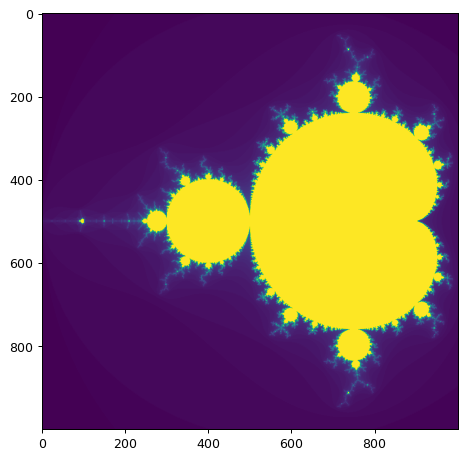

In [20]:
def mandelbrot(z, max_iters):
    c = z
    for n in range(max_iters):
        if abs(z) > 2:
            return n
        z = z * z + c
    return max_iters


def mandelbrot_set(xmin, xmax, ymin, ymax, width, height, max_iters):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i] + 1j*r2[j], max_iters)
    return n3

mandel = mandelbrot_set(-2, 0.5, -1.25, 1.25, 1000, 1000, 100)
plt.imshow(mandel.T)
%timeit mandelbrot_set(-2, 0.5, -1.25, 1.25, 1000, 1000, 100)

In [ ]:
# Complete the code to provide a solution to Exercise 5:
def mandelbrot_set_jax(xmin, xmax, ymin, ymax, width, height, max_iters):

    @jax.jit
    def mandelbrot_scan(z):
        def body(carry, _):
            c = carry
            return c*c+z, jnp.abs(c) > 2    
        carry, out = jax.lax.scan(body, z, None, length=max_iters)
        #We get the first index where absolute value was > 2, or max_iters
        return jnp.nonzero(out, size=1, fill_value=max_iters)[0][0].astype(float)

    r1 = jnp.linspace(xmin, xmax, width)
    r2 = jnp.linspace(ymin, ymax, height)
    y_vmap_f = jax.vmap(lambda x, y:mandelbrot_scan(x + 1j*y), (None, 0))
    xy_vmap_f = jax.vmap(y_vmap_f, (0, None))    
    return xy_vmap_f(r1, r2)

mandelbrot_set_fast = jax.jit(mandelbrot_set_jax, static_argnums=[4, 5, 6])

mandel = mandelbrot_set_fast(-2, 0.5, -1.25, 1.25, 1000, 1000, 100)
plt.imshow(jnp.abs(mandel).T)
%timeit mandelbrot_set_fast(-2, 0.5, -1.25, 1.25, 1000, 1000, 100)

718 ms ± 9.8 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


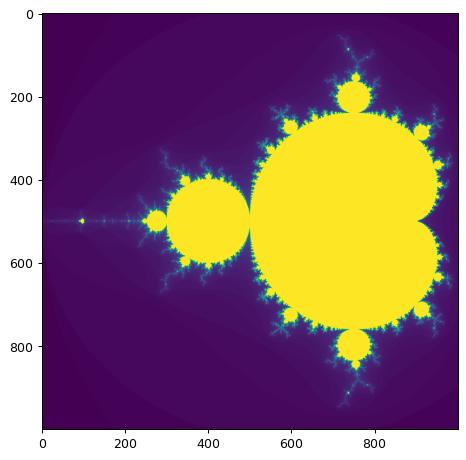

In [21]:
#Another possible solution for Exercise 5
def mandelbrot_set_jax(xmin, xmax, ymin, ymax, width, height, max_iters):
    
    def mandelbrot(z):
        return jnp.real(jax.lax.while_loop(lambda val:(val[0] < max_iters) & (jnp.abs(val[1]) <= 2.),
                                           lambda val:jnp.array([val[0]+1, val[1]*val[1]+z]),
                                           jnp.array([0, z]))[0])
    
    r1 = jnp.linspace(xmin, xmax, width)
    r2 = jnp.linspace(ymin, ymax, height)
    y_vmap_f = jax.vmap(lambda x, y:mandelbrot(x + 1j*y), (None, 0))
    xy_vmap_f = jax.vmap(y_vmap_f, (0, None))
    return xy_vmap_f(r1, r2)

mandelbrot_set_fast = jax.jit(mandelbrot_set_jax, static_argnums=[4, 5, 6])
mandel = mandelbrot_set_fast(-2, 0.5, -1.25, 1.25, 1000, 1000, 100)
plt.imshow(mandel.T)
%timeit mandelbrot_set_fast(-2, 0.5, -1.25, 1.25, 1000, 1000, 100)

## Further Reading 
 1. The Jax autodiff cookbook: https://docs.jax.dev/en/latest/notebooks/autodiff_cookbook.html
 2. Control flow and logical operators with JIT: https://docs.jax.dev/en/latest/control-flow.html